# Fraud Detection using Unsupervised Learning
---
Taken from [Fraud Detection Handbook](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html) and [Robin Teuwen's Kaggle notebook](https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders)

Data taken from [Machine Learning Group ULB's Credit Card Fraud dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

## Pre-Requisites

### Importing the Libraries

In [1]:
# Turning off Tensorflow loggings
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
# Importing some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

# Importing TensorFlow and Keras Tuner
import tensorflow as tf
import keras_tuner as kt

# Importing the K-Means model
from sklearn.cluster import KMeans

# Importing the Gaussian Mixture model
from sklearn.mixture import GaussianMixture

# Importing datapreprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Importing metrics from Scikit-Learn
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, f1_score, precision_score, recall_score

In [3]:
# Plot styling
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
# Setting some save paths
graph_path = "Graphs"
autoencoder_path = "Models//Autoencoder"

# Creating paths if they don't exist
for path in [graph_path, autoencoder_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
# Checking if GPU is available
if tf.test.is_gpu_available():
    print(tf.test.gpu_device_name())
else:
    print("No GPU available")

/device:GPU:0


### Importing the Dataset

In [6]:
# Importing the data in
data = pd.read_csv("Dataset//creditcard.csv")

# Previewing the data
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Exploration

In [7]:
# Getting the shape of the data
data.shape

(284807, 31)

In [8]:
# Getting a description of the data
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
# Checking for missing values
(data.isnull().sum() != 0).sum()

0

In [10]:
# Removing the time column
data = data.drop("Time", axis=1)

In [11]:
# Checking the distribution of the target variable
data["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [12]:
# Ratio of non-fraud to fraud
data["Class"].value_counts()[0]/ data["Class"].value_counts()[1]

577.8760162601626

## Data Preprocessing

In [13]:
# Separating the data into fraud and not fraud
fraud = data[data["Class"] == 1]
not_fraud = data[data["Class"] == 0]

In [14]:
# Selecting 492 random non-fraudulent transactions
X_test_not_fraud = not_fraud.sample(n=fraud.shape[0], random_state=42)

# Separating the remaining non-fraudulent transactions and the fraudulent transactions for the dev set
X_test = pd.concat([X_test_not_fraud, fraud], axis=0).sample(frac=1, random_state=42)
y_test = X_test["Class"]
X_test = X_test.drop("Class", axis=1)

# Getting only the non-fraudulent transactions for the training set and the dev set
X_train = not_fraud.drop(X_test_not_fraud.index)
y_train = X_train["Class"]
X_train = X_train.drop("Class", axis=1)

# Splitting the training data into train and dev sets
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [15]:
# Scaling the data
scaler = StandardScaler()
scaler.fit(X_train)

# Transforming the data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_dev = scaler.transform(X_dev)

## Modelling the Data

### Helper Functions

In [16]:
def plot_roc_curve(label, prediction, title=None, save=False):

    # Setting up a couple of plot settings
    title = title if title is not None else "the Model"

    # Calculating the FPR and TPR score at different thresholds
    fpr, tpr, thresholds = roc_curve(label, prediction)

    # Setting the figure size
    plt.figure(figsize=(10, 6))

    # Plotting the ROC curve
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0, 1], [0, 1], label="Random Classifier")

    # Plot settings
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for {}".format(title))
    plt.legend()
    sns.despine()

    # Saving the plot if specified
    if save and title is not None:
        path = os.path.join(graph_path, "roc_{}.png".format(str.lower(title)))
        plt.savefig(path, dpi=300, bbox_inches="tight", transparent=True)

    # Displaying the plot
    plt.show()

In [17]:
def plot_precision_recall_curve(label, prediction, title=None, save=False):

    # Setting up a couple of plot settings
    title = title if title is not None else "the Model"

    # Calculating the precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(label, prediction)

    # Setting the figure size
    plt.figure(figsize=(10, 6))

    # Plotting the precision and recall for different thresholds
    plt.plot(thresholds, precision[1:], label="Precision")
    plt.plot(thresholds, recall[1:], label="Recall")

    # Plot settings
    plt.xlabel("Threshold")
    plt.ylabel("Precision/Recall")
    plt.title("Precision/Recall to Threshold Curve for {}".format(title))
    plt.legend()
    sns.despine()

    # Saving the plot if specified
    if save and title is not None:
        path = os.path.join(graph_path, "pr_{}.png".format(str.lower(title)))
        plt.savefig(path, dpi=300, bbox_inches="tight", transparent=True)

    # Showing the plot
    plt.show()

In [18]:
def plot_confusion_matrix(label, prediction, title=None, save=False):

    # Setting up a couple of plot settings
    title = title if title is not None else "the Model"

    # Creating the confusion matrix
    cm = confusion_matrix(label, prediction)

    # Setting the figure size
    plt.figure(figsize=(10, 6))

    # Plotting the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    # Plot settings
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for {}".format(title))

    # Saving the plot if specified
    if save and title is not None:
        path = os.path.join(graph_path, "cm_{}.png".format(str.lower(title)))
        plt.savefig(path, dpi=300, bbox_inches="tight", transparent=True)

    # Showing the plot
    plt.show()
    

In [19]:
def plot_dist(non_fraud, fraud, bins, metric, title=None, save=False):

    # Setting up a couple of plot settings
    metric = metric if metric is not None else "Metric"
    title = title if title is not None else "the Model"

    # Setting up the plot
    plt.figure(figsize=(10, 6))

    # Plotting the histogram of distances
    sns.histplot(non_fraud, bins=bins, alpha=0.5, label='Not Fraud')
    sns.histplot(fraud, bins=bins, alpha=0.5, label='Fraud')

    # Plot settings
    plt.xlabel(metric)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {metric} for {title}")
    plt.legend()
    sns.despine()

    # Saving the plot if specified
    if save and title is not None:
        path = os.path.join(graph_path, "dist_{}.png".format(str.lower(title)))
        plt.savefig(path, dpi=300, bbox_inches="tight", transparent=True)

    # Showing the plot
    plt.show()

In [20]:
def check_mean_std(raw_output, metric, verbose=True):
    
    # Calculating the mean and standard deviation of the raw output
    mean = np.mean(raw_output)
    std = np.std(raw_output)

    # Printing the mean and standard deviation if specified
    if verbose:
        print(f"Mean {metric}: {mean}")
        print(f"Standard Deviation {metric}: {std}")

    # Returning the mean and standard deviation
    return mean, std

In [21]:
def classifier_metrics(label, prediction):
    
    # Accuracy score
    accuracy = accuracy_score(label, prediction)

    # F1 score
    f1 = f1_score(label, prediction)

    # Precision score
    precision = precision_score(label, prediction)

    # Recall score
    recall = recall_score(label, prediction)

    # AUC score
    auc = roc_auc_score(label, prediction)

    # Returning the scores
    return {"Accuracy": accuracy, "F1": f1, "Precision": precision, "Recall": recall, "AUC": auc}

### K-Means Clustering

#### Training the Model

In [22]:
# Creating the K-Means model
kmeans = KMeans(n_clusters=1, random_state=42, n_init=10, max_iter=1000)

# Fitting the model
kmeans.fit(X_train)

KMeans(max_iter=1000, n_clusters=1, n_init=10, random_state=42)

#### Determining the Threshold from the Dev Set

In [23]:
# Getting the distances of the dev set from the clusters
km_distance = kmeans.transform(X_dev).reshape(-1)

In [24]:
# Getting the mean and standard deviation of the distances
km_mean, km_std = check_mean_std(km_distance, "Distance")

Mean Distance: 4.739340100977101
Standard Deviation Distance: 2.5809834418758544


In [25]:
# Setting the K-Means threshold
km_threshold = km_mean + km_std

# Displaying the threshold
print("K-Means Threshold: {}".format(km_threshold))

K-Means Threshold: 7.320323542852956


#### Testing the Model on the Test Set

In [26]:
# Raw distance scores for the test set
km_distance_test = kmeans.transform(X_test).reshape(-1)

# Getting the predictions
km_pred_test = (km_distance_test  > km_threshold).astype(int)

In [27]:
# AUC on raw distance scores
roc_auc_score(y_test, km_distance_test)

0.958101989556481

In [28]:
# Evaluating the model
km_test_eval = classifier_metrics(y_test, km_pred_test)

# Displaying the evaluation metrics
km_test_eval

{'Accuracy': 0.9136178861788617,
 'F1': 0.9108079748163694,
 'Precision': 0.9414316702819957,
 'Recall': 0.8821138211382114,
 'AUC': 0.9136178861788617}

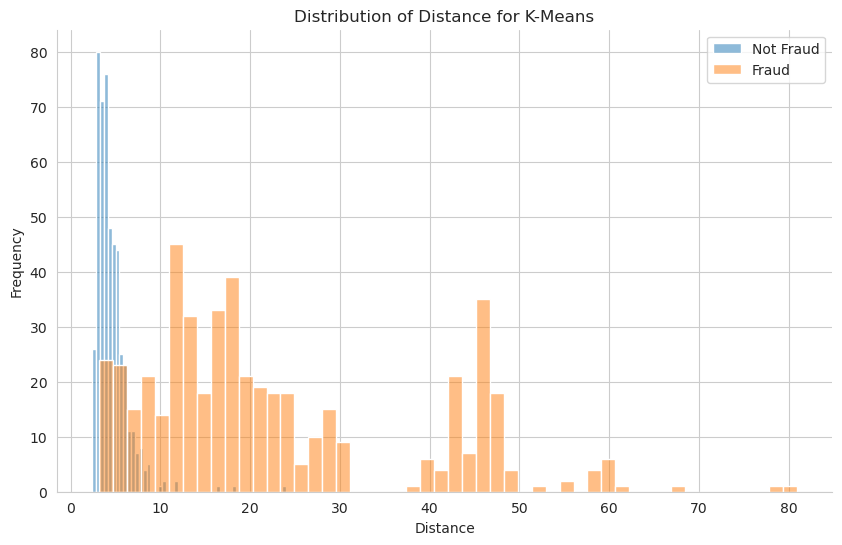

In [29]:
# Distribution of distances
plot_dist(km_distance_test[y_test == 0], km_distance_test[y_test == 1], 50, "Distance", "K-Means")

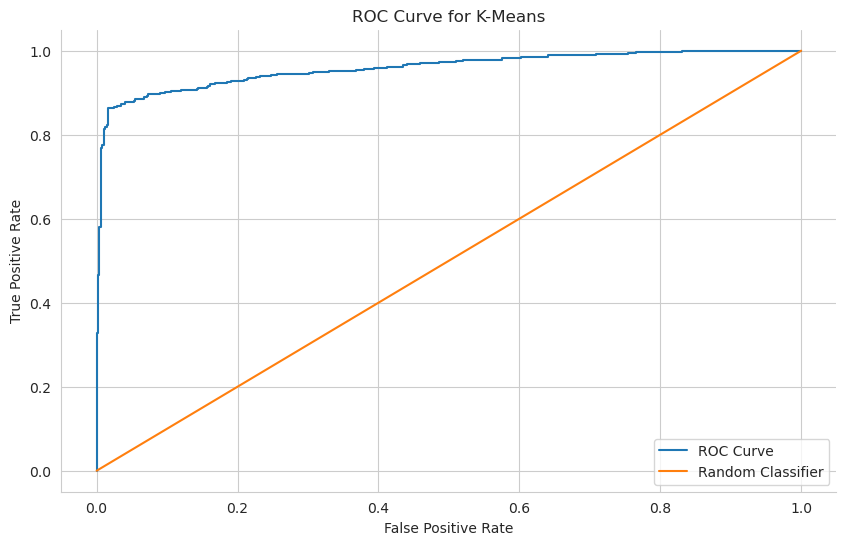

In [30]:
# Plotting the ROC curve
plot_roc_curve(y_test, km_distance_test , title="K-Means")

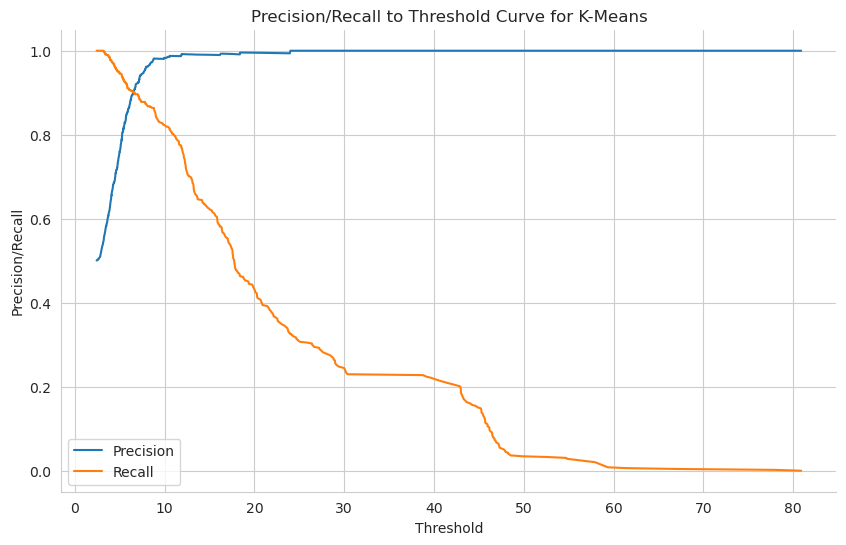

In [31]:
# Plotting the precision/recall curve
plot_precision_recall_curve(y_test, km_distance_test , title="K-Means")

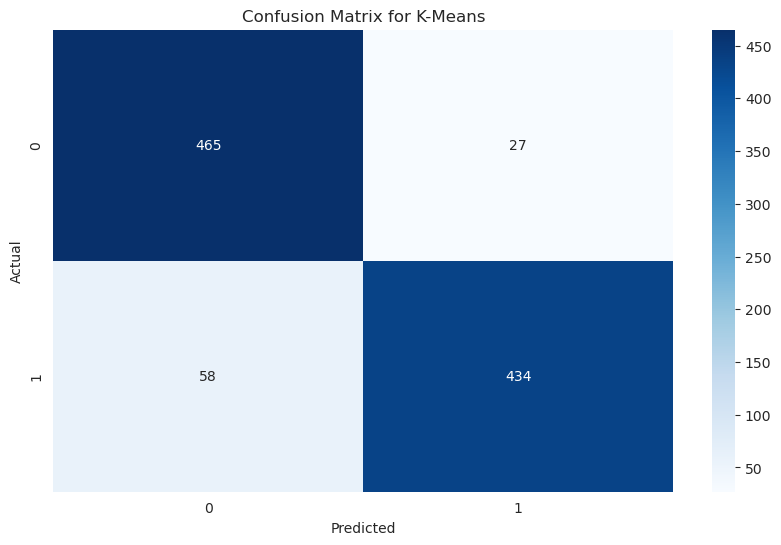

In [32]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, km_pred_test , title="K-Means")

### Gaussian Mixture

#### Training the Model

In [33]:
# Creating the Gaussian Mixture model
gmm = GaussianMixture(n_components=1, random_state=42, n_init=10, max_iter=1000)

# Fitting the model
gmm.fit(X_train)

GaussianMixture(max_iter=1000, n_init=10, random_state=42)

#### Determining the Threshold from the Dev Set

In [34]:
# Getting the distances of the dev set from the clusters
gmm_density = np.abs(gmm.score_samples(X_dev))

In [35]:
# Getting the mean and standard deviation of the Log-Likelihoods
gmm_mean, gmm_std = check_mean_std(gmm_density, "Log-Likelihood")

Mean Log-Likelihood: 39.54975005973488
Standard Deviation Log-Likelihood: 68.07553059199907


In [36]:
# Setting the GMM threshold
gmm_threshold = gmm_mean + gmm_std

# Displaying the threshold
print("GMM Threshold: {}".format(gmm_threshold))

GMM Threshold: 107.62528065173396


#### Testing the Model on the Test Set

In [37]:
# Raw density scores for the test set
gmm_density_test = np.abs(gmm.score_samples(X_test))

# Getting the predictions
gmm_pred_test = (gmm_density_test > gmm_threshold).astype(int)

In [38]:
# AUC on raw density scores
roc_auc_score(y_test, gmm_density_test)

0.9599072972437043

In [39]:
# Evaluating the model
gmm_test_eval = classifier_metrics(y_test, gmm_pred_test)

# Displaying the evaluation metrics
gmm_test_eval

{'Accuracy': 0.9115853658536586,
 'F1': 0.9036544850498338,
 'Precision': 0.9927007299270073,
 'Recall': 0.8292682926829268,
 'AUC': 0.9115853658536585}

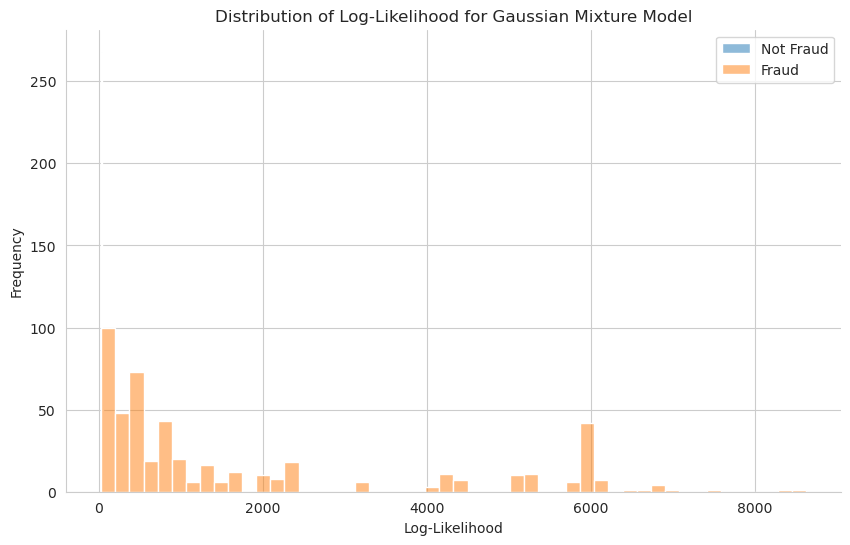

In [40]:
# Distribution of Log-Likelihood
plot_dist(gmm_density_test[y_test == 0], gmm_density_test[y_test == 1], 50, "Log-Likelihood", "Gaussian Mixture Model")

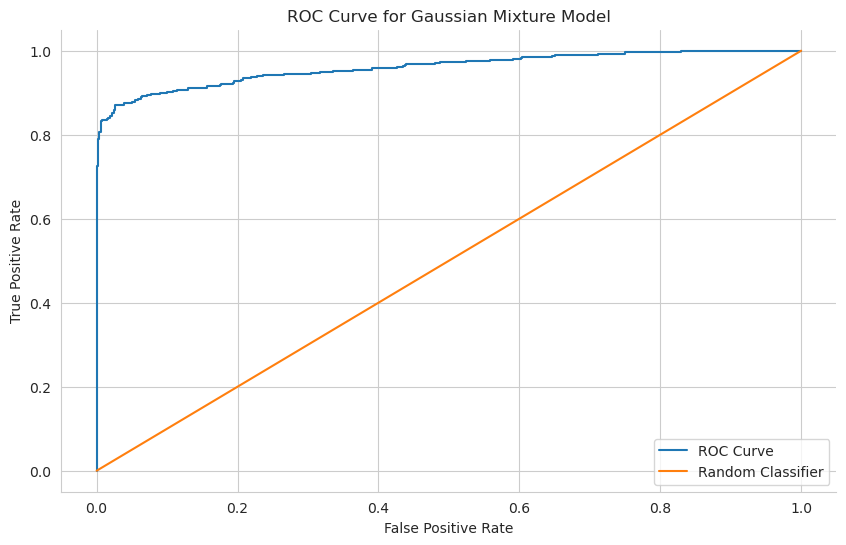

In [41]:
# Plotting the ROC curve
plot_roc_curve(y_test, gmm_density_test, title="Gaussian Mixture Model")

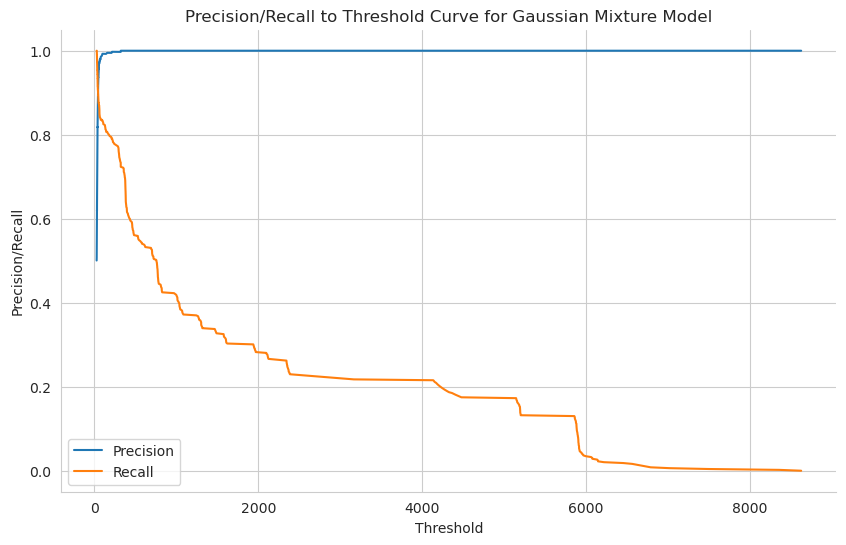

In [42]:
# Plotting the precision/recall curve
plot_precision_recall_curve(y_test, gmm_density_test, title="Gaussian Mixture Model")

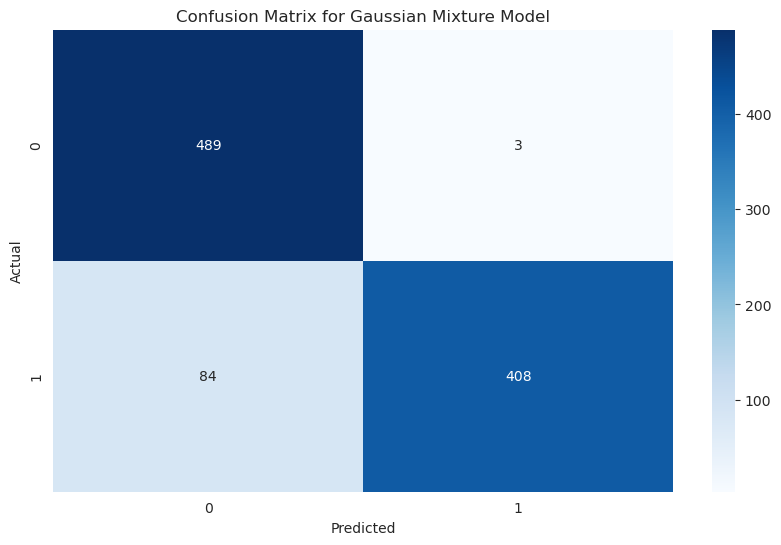

In [43]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, gmm_pred_test, title="Gaussian Mixture Model")

### Autoencoder

#### Building the AutoEncoder

In [44]:
# Creating the Encoder model
class Encoder(tf.keras.Model):
    def __init__(self, input_size, latent_size=2, hidden_layers=2,
                 activation="elu", dropout=0.2):
        
        # Initializing the model using the super() function
        super(Encoder, self).__init__()

        # Calculating the number of units in each hidden layer
        self.hidden_units = (latent_size ** np.arange(2, hidden_layers + 1))[::-1].tolist() + [latent_size]
        
        # Creating the hidden layers
        self.layer_stack = tf.keras.Sequential(name="encoder_stack")
        for units in self.hidden_units:
            self.layer_stack.add(tf.keras.layers.Dense(units, activation=activation))

        # Creating the dropout layer to give noise to the input (only during training)
        self.dropout = tf.keras.layers.Dropout(dropout, name="input_noise")
        
    def call(self, x):
        # Adding noise to the input (only during training)
        x = self.dropout(x)

        # Passing the input through the hidden layers
        x = self.layer_stack(x)
        return x

In [45]:
# Creating the Decoder model
class Decoder(tf.keras.Model):
    def __init__(self, input_size, output_size, hidden_layers=2,
                 encoder_units=None, activation="elu"):
        
        # Initializing the model using the super() function
        super(Decoder, self).__init__()

        # Creating the hidden layers
        self.layer_stack = tf.keras.Sequential(name="decoder_stack")

        # Calculating the number of units in each hidden layer if not specified
        if encoder_units is None: 

            self.hidden_units = (input_size ** np.arange(2, hidden_layers + 1)) + [output_size]
        
        # Using the encoder units if specified
        else:
            self.hidden_units = encoder_units[::-1][1:] + [output_size]

        # Creating the hidden layers
        self.layer_stack = tf.keras.Sequential(name="decoder_stack")

        # Creating the hidden layers
        for units in list(self.hidden_units):
            self.layer_stack.add(tf.keras.layers.Dense(units, activation=activation))

    def call(self, x):
        # Passing the input through the hidden layers
        x = self.layer_stack(x)
        return x

In [46]:
# Creating the Autoencoder model
class Autoencoder(tf.keras.Model):
    def __init__(self, input_size, latent_size, hidden_layers=2, activation='elu', dropout=0.2):

        # Initializing the model using the super() function
        super(Autoencoder, self).__init__()

        # Creating the encoder
        self.encoder = Encoder(input_size=input_size, latent_size=latent_size, 
                               hidden_layers=hidden_layers, activation=activation, dropout=dropout)
        
        # Creating the decoder
        self.decoder = Decoder(input_size=latent_size, output_size=input_size, 
                               hidden_layers=hidden_layers, encoder_units=self.encoder.hidden_units, activation=activation)

    def call(self, x):
        # Passing the input through the encoder and decoder
        x = self.encoder(x)

        # Passing the output of the encoder through the decoder
        x = self.decoder(x)
        return x

#### Tuning the Autoencoder

In [47]:
class AutoencoderTune(kt.HyperModel):
    def __init__(self, name=None, tunable=True, input_size=X_train.shape[1]):
        super().__init__(name, tunable)

        # Setting the input size (it's fixed for this dataset)
        self.input_size = input_size

    def param_choice(self, hp):
        # Defining the hyperparameters to tune
        latent_size = hp.Choice("latent_size", values=[2, 3, 4])
        hidden_layers = hp.Int("hidden_layers", min_value=2, max_value=8, step=1)
        learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")
        activation = hp.Choice("activation", values=["elu", "relu", "tanh", "leaky_relu"])
        dropout_rate = hp.Float("dropout_rate", min_value=0.0, max_value=0.5, step=0.05)
        return latent_size, learning_rate, activation, hidden_layers, dropout_rate
    
    def build(self, hp):
        # Getting the hyperparameters
        latent_size, learning_rate, activation, hidden_layers, dropout_rate = self.param_choice(hp)

        # TensorFlow random seed
        tf.keras.utils.set_random_seed(42)

        # Creating the model
        model = Autoencoder(input_size=self.input_size, latent_size=latent_size, hidden_layers=hidden_layers,
                            activation=activation, dropout=dropout_rate)
        
        # Compiling the model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

        return model
    
    def fit(self, hp, model, *args, **kwargs):
        # Fitting the model
        return model.fit(*args, **kwargs)

In [48]:
# Training hyperparams
input_size = X_train.shape[1]
batch_size = 2048
epochs = 500
early_stopping_patience = 100

# Setting up the tuner
tuner = kt.Hyperband(AutoencoderTune(input_size=input_size), objective=kt.Objective('val_loss', 'min'), 
                     max_epochs=epochs, factor=5, directory=os.path.join(autoencoder_path, 'hyperband'), 
                     project_name="autoencoder", seed=42, overwrite=False)

# Setting up the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience,
                                                  restore_best_weights=True)   

In [49]:
# # Fitting the tuner
# tuner.search(X_train, X_train, epochs=epochs, batch_size=batch_size, 
#              validation_data=(X_dev, X_dev),callbacks=[early_stopping])

# # Saving the optimal hyperparameters
# joblib.dump(tuner.get_best_hyperparameters()[0].values, os.path.join(autoencoder_path, "best_hps.pkl"))

In [50]:
# Getting the optimal hyperparameters
best_hps_ae = joblib.load(os.path.join(autoencoder_path, "best_hps.pkl"))
best_hps_ae

{'latent_size': 4,
 'hidden_layers': 5,
 'learning_rate': 0.0006461809763075458,
 'activation': 'leaky_relu',
 'dropout_rate': 0.0,
 'tuner/epochs': 500,
 'tuner/initial_epoch': 100,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0189'}

#### Training the Autoencoder

In [51]:
# Clearing the session
tf.keras.backend.clear_session()

# TensorFlow random seed
tf.keras.utils.set_random_seed(42)

# Creating the model
model = Autoencoder(input_size=input_size, latent_size=best_hps_ae["latent_size"],
                    hidden_layers=best_hps_ae["hidden_layers"], activation=best_hps_ae["activation"],
                    dropout=best_hps_ae["dropout_rate"])

# Building the model
model.build(input_shape=(None, input_size))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps_ae["learning_rate"]), loss="mse")

# Previewing the model architecture
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  310676    
                                                                 
 decoder (Decoder)           multiple                  310701    
                                                                 
Total params: 621,377
Trainable params: 621,377
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Training hyperparams
input_size = X_train.shape[1]
batch_size = 2048
epochs = 500
early_stopping_patience = 100

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=early_stopping_patience, mode="min", 
                                                  restore_best_weights=True, verbose=0)

# Model checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(autoencoder_path, 'current_best_model'),   
                                                      monitor="val_loss", save_best_only=True, mode="min", verbose=0)

In [53]:
# # Training the model
# history = model.fit(X_train, X_train, 
#                     validation_data = (X_dev, X_dev),
#                     batch_size=batch_size, epochs=epochs, 
#                     callbacks=[early_stopping, model_checkpoint])

# # Saving the training history
# joblib.dump(history.history, os.path.join(autoencoder_path, "losses.pkl"))

# # Saving the model
# tf.keras.models.save_model(model, os.path.join(autoencoder_path, "fraud_autoencoder"))

In [54]:
# Loading the model
model = tf.keras.models.load_model(os.path.join(autoencoder_path, "fraud_autoencoder"))

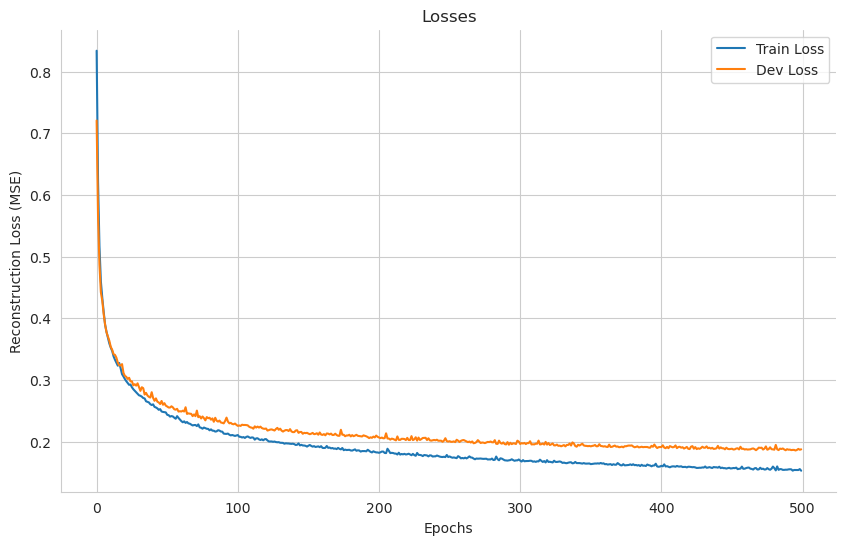

In [55]:
# Reloading the losses
losses = joblib.load(os.path.join(autoencoder_path, "losses.pkl"))

# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the training and dev losses
plt.plot(losses['loss'], label="Train Loss")
plt.plot(losses['val_loss'], label="Dev Loss")

# Plot settings
plt.xlabel("Epochs")
plt.ylabel("Reconstruction Loss (MSE)")
plt.title("Losses")
plt.legend()
sns.despine()

# Showing the plot
plt.show()

#### Determining the Threshold from the Dev Set

Interesting threshold idea:
- Feature-wise threshold (take the average reconstruction loss for each feature in the clean examples). If say one or more passes that threshold, flag as anomaly. Idea taken from [Torabi et.al (2023)](https://cybersecurity.springeropen.com/articles/10.1186/s42400-022-00134-9)
- Z-score and if the Z-score is greater than 3, flag as anomaly.
- Convert losses to Robust Z-Score and if the |score| > 3.5 (recommendation), most likely it's and outlier. Taken from this [Medium Article](https://medium.com/@joaopedroferrazrodrigues/outliers-make-us-go-mad-univariate-outlier-detection-b3a72f1ea8c7)
$$\text{Robust Z-Score} = \frac{0.6745(x - \tilde{x})}{MAD}$$
where $\tilde{x}$ is the median and MAD is the median absolute deviation.


In [56]:
# Reconstruction loss for each sample
sample_recon_loss = lambda label, pred: tf.reduce_mean(tf.square(tf.subtract(label, pred)), axis=1).numpy()

# Getting the reconstruction loss for the dev set
dev_recon_loss = sample_recon_loss(X_dev, model.predict(X_dev, verbose=0))

In [57]:
# Getting the mean and standard deviation of the reconstruction for the dev set
ae_mean, ae_std = check_mean_std(dev_recon_loss, "Sample Mean Squared Error")

Mean Sample Mean Squared Error: 0.18732905018145188
Standard Deviation Sample Mean Squared Error: 0.4876558063248407


In [58]:
# Setting the AE threshold
ae_threshold = ae_mean + ae_std

# Displaying the AE threshold
ae_threshold

0.6749848565062926

#### Testing the Model on the Test Set

In [59]:
# Raw reconstruction loss for each sample
ae_recon_test = sample_recon_loss(X_test, model.predict(X_test, verbose=0))

# Getting the predictions
ae_pred_test = (ae_recon_test > ae_threshold).astype(int)

In [60]:
# AUC on raw reconstruction loss
roc_auc_score(y_test, ae_recon_test)

0.9612044748496266

In [61]:
# Evaluating the model
ae_test_eval = classifier_metrics(y_test, ae_pred_test)

# Displaying the results
ae_test_eval

{'Accuracy': 0.9034552845528455,
 'F1': 0.8970747562296859,
 'Precision': 0.9605568445475638,
 'Recall': 0.8414634146341463,
 'AUC': 0.9034552845528455}

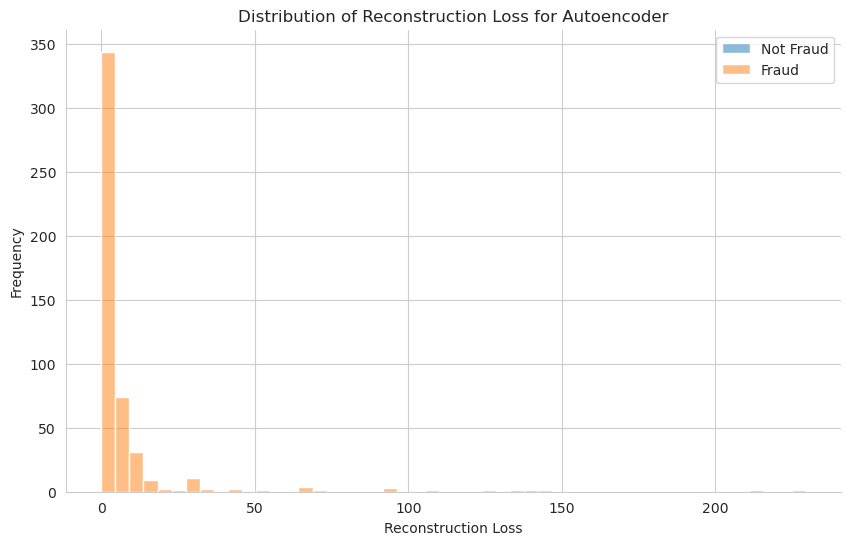

In [62]:
# Distribution of the Reconstruction Loss
plot_dist(ae_recon_test[y_test == 0], ae_recon_test[y_test == 1], 50, 
          "Reconstruction Loss", "Autoencoder")

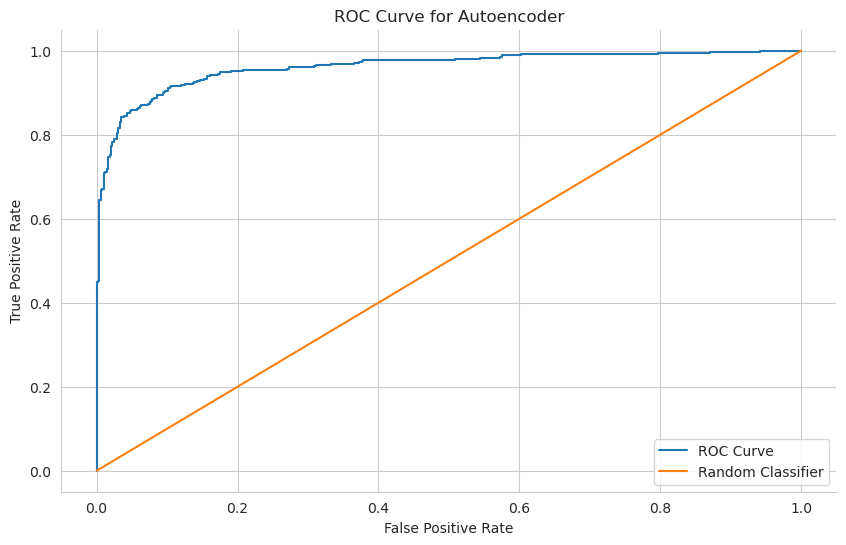

In [63]:
# Plotting the ROC curve
plot_roc_curve(y_test, ae_recon_test, "Autoencoder")

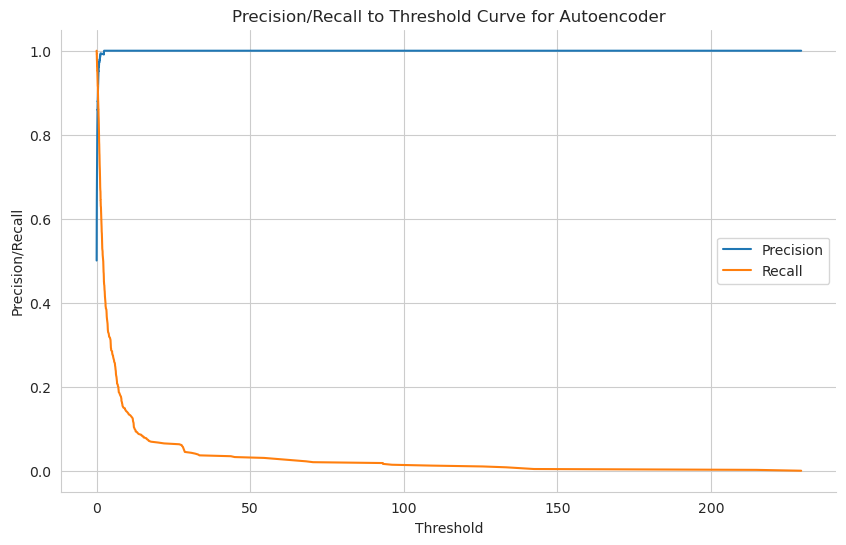

In [64]:
# Plotting the Precision/Recall curve
plot_precision_recall_curve(y_test, ae_recon_test, "Autoencoder")

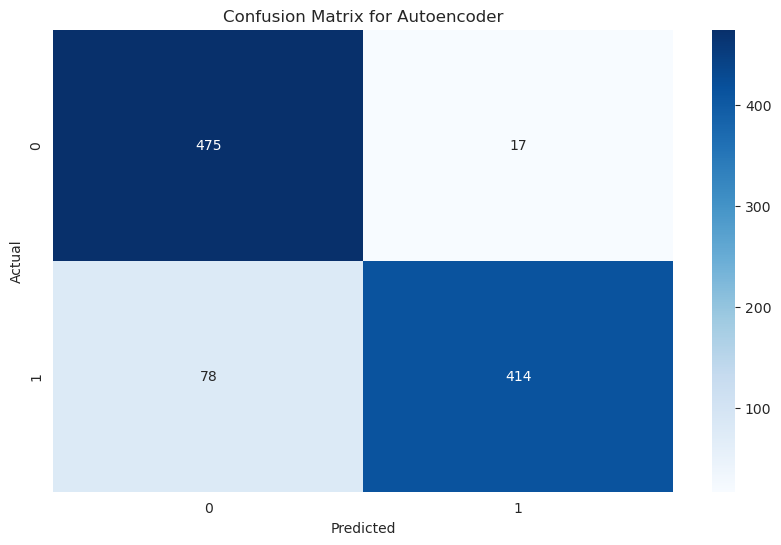

In [65]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, ae_pred_test, "Autoencoder")